In [1]:
# Pandas library for the pandas dataframes
import pandas as pd    
import numpy as np

# Import Scikit-Learn library for decision tree models
import sklearn         
from sklearn import linear_model, datasets
from sklearn.utils import resample
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import f_regression, SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


# Import plotting libraries
import seaborn as sns
import matplotlib 
from matplotlib import pyplot as plt


# Set larger fontsize for all plots
matplotlib.rcParams.update({'font.size': 18})
from IPython.display import clear_output

# Command to automatically reload modules before executing cells
# not needed here but might be if you are writing your own library 
%load_ext autoreload
%autoreload 2

# Import cleaning and splitting functions
from clean_split_data import clean_data
from clean_split_data import split_data

### Data

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data = clean_data(data)
X_train, X_test, y_train, y_test = split_data(data)

### Classifier Processing

In [4]:
max_depths = [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40]
list_mse = []
for depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    list_mse.append(mean_squared_error(y_test, y_pred))

Text(0.5, 1.0, 'MSE at different max_depths')

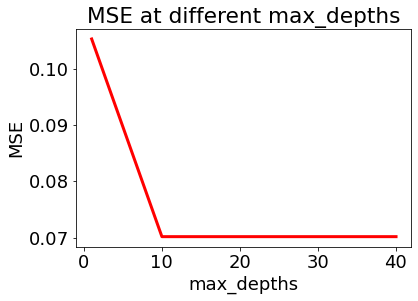

In [5]:
plt.plot(max_depths, list_mse, c='r', linewidth=3)
plt.xlabel('max_depths')
plt.ylabel('MSE')
plt.title('MSE at different max_depths')

Therefore pick a max_depth of 10 for the decision tree.

In [6]:
clf = DecisionTreeClassifier(max_depth=10, random_state=42)
n_estimators = [1, 10, 20, 30, 40]
n_mse_list = []
for estimators in n_estimators:
    clf_bag = BaggingClassifier(base_estimator=clf, n_estimators=estimators, random_state=42)
    clf_bag.fit(X_train, y_train)
    y_bag = clf_bag.predict(X_test)
    n_mse_list.append(mean_squared_error(y_test, y_bag))

Text(0.5, 1.0, 'MSE at different n_estimators')

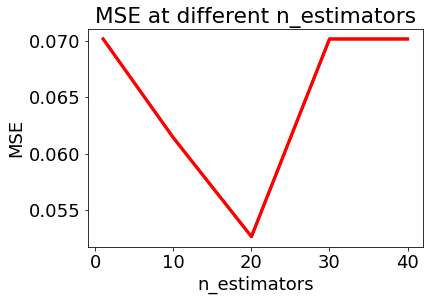

In [7]:
plt.plot(n_estimators, n_mse_list, c='r', linewidth=3)
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.title('MSE at different n_estimators')
plt.plot(n_estimators, n_mse_list, c='r', linewidth=3)
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.title('MSE at different n_estimators')

The bagging model has lowest MSE at 20 base models.

### Classifier

In [22]:
# Default criterion is GINI index
clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf_bag = BaggingClassifier(base_estimator=clf, n_estimators=20, random_state=42)
clf_bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                        random_state=42),
                  n_estimators=20, random_state=42)

In [23]:
def predict(test_data):
    
    #test_data = pd.DataFrame(test_data).T
    y_pred = clf_bag.predict(test_data)
   
    return y_pred

In [24]:
y_pred = clf_bag.predict(X_test)

In [25]:
'''Accuracy and MSE Using ALL 10 features'''

print("Prediction accuracy MSE: ", mean_squared_error(y_test, y_pred))
print("Accuracy score", accuracy_score(y_test, y_pred))
#print('R-Squared Score',r2_score(y_test,y_pred))

Prediction accuracy MSE:  0.05263157894736842
Accuracy score 0.9473684210526315


### Sample Train, Test, Split Results

In [26]:
def sample_results():
    ''' 
    Returns the results and confusion matrix of the sample dataset from Breast Cancer Wisconsin Dataset.
    '''
    y_pred = clf_bag.predict(X_test)
    print("Prediction accuracy MSE: ", mean_squared_error(y_test, y_pred))
    print("Mean accuracy on test set", clf_bag.score(X_test, y_test))
    print("The confusion matrix for the sample dataset using a decision tree is displayed below: ")
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(clf_bag, X_test, y_test)
    plt.show()
    
    return

Prediction accuracy MSE:  0.05263157894736842
Mean accuracy on test set 0.9473684210526315
The confusion matrix for the sample dataset using a decision tree is displayed below: 
              precision    recall  f1-score   support

           0       0.97      0.94      0.96        71
           1       0.91      0.95      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114



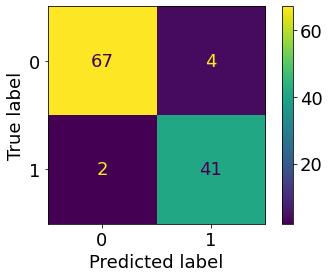

In [27]:
sample_results()

### Backwards Stepwise Feature Selection

In [28]:
'''Load the cleaned original dataset for below use'''
X = data[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
y = data.diagnosis

'''A list of for the for-loop'''
n = [1,2,3,4,5,6,7,8,9]

list_MSE=[]
list_AC=[]
list_MSE_1=[]
list_AC_1=[]
selected_features = []

clf = DecisionTreeClassifier(max_depth=10, random_state=42)

for i in n:
    '''Only passing the training data set into the Feature Selector'''
    '''Any preprocessing method should not be fitted on the whole dataset to prevent carrying information from the train set
       to test set'''
    sbs_backward = SequentialFeatureSelector(clf,
                                             n_features_to_select=i,
                                             direction='backward').fit(X_train, y_train)
    selected = sbs_backward.get_support(indices=True)

    '''passing the selected features to the orginial dataset for each number of i'''
    f_names = np.array(X.columns)
    x_manip = X[f_names[selected]]
    selected_features.append(f_names[selected])
    
    '''Spliting the original data set with selected feature for each number of i'''
    X_train1, X_test1, y_train1, y_test1 = train_test_split(x_manip, y , test_size=0.2, random_state=42) 
    
    model = BaggingClassifier(base_estimator=clf, n_estimators=20, random_state=42)
    model.fit(X_train1, y_train1)
    
    y_pred1 = model.predict(X_test1)
    y_pred2 = model.predict(X_train1)
    
    list_AC.append(accuracy_score(y_test1, y_pred1))
    list_AC_1.append(accuracy_score(y_train1, y_pred2))
    list_MSE.append(mean_squared_error(y_test1, y_pred1))
    list_MSE_1.append(mean_squared_error(y_train1, y_pred2))

<function matplotlib.pyplot.show(close=None, block=None)>

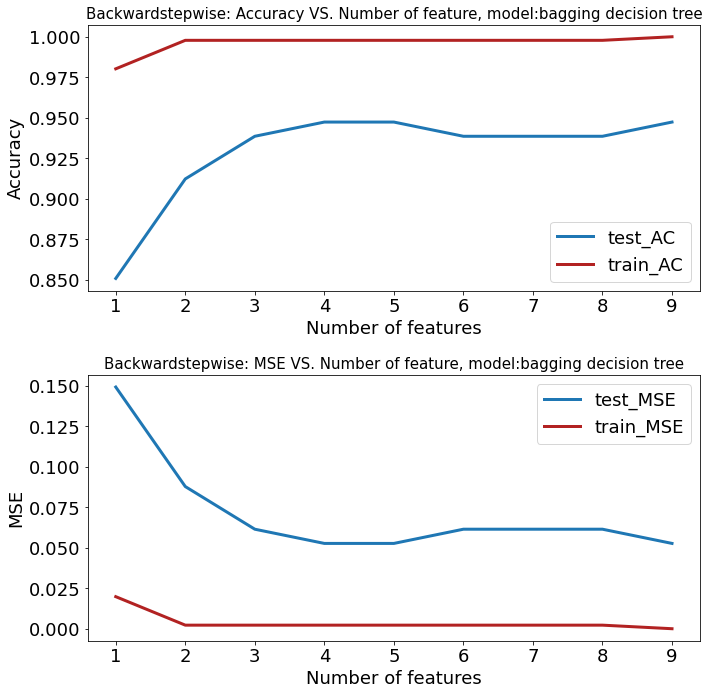

In [29]:
fig,ax = plt.subplots(2,1,figsize=(10,10))

#ax[1].plot(input_features_count, list_test_R2, label='Test Set R2', c='r', linewidth=4)
#ax[1].plot(input_features_count, list_training_R2, label='Train Set R2', c='b', linewidth=4)
#ax[1].set_xlabel('Input Features')
#ax[1].set_ylabel('R2')
#ax[1].set_title('R2 of Train and Test sets vs Input Features')
#ax[1].legend()

ax[0].plot(n, list_AC, linewidth=3 ,alpha=1,label='test_AC')
ax[0].plot(n, list_AC_1, linewidth=3, alpha=1,c='FireBrick',label='train_AC')
ax[0].set_title('Backwardstepwise: Accuracy VS. Number of feature, model:bagging decision tree', fontsize=15)
ax[0].set_xlabel('Number of features')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(n, list_MSE, linewidth=3 ,alpha=1,label='test_MSE')
ax[1].plot(n, list_MSE_1, linewidth=3, alpha=1,c='FireBrick',label='train_MSE')
ax[1].set_title('Backwardstepwise: MSE VS. Number of feature, model:bagging decision tree', fontsize=15)
ax[1].set_xlabel('Number of features')
ax[1].set_ylabel('MSE')
ax[1].legend()

plt.tight_layout()
plt.show

Prediction accuracy MSE:  0.05263157894736842
Mean accuracy on test set 0.9473684210526315
The confusion matrix for the sample dataset using a decision tree is displayed below: 
              precision    recall  f1-score   support

           0       0.97      0.94      0.96        71
           1       0.91      0.95      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114



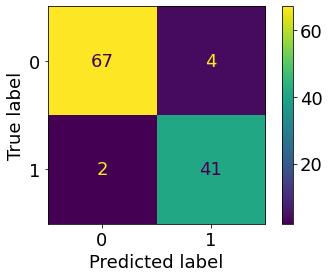

In [30]:
'''This matrix is for Backward Stepwise SVM with 9 features'''
plot_confusion_matrix(model, X_test1, y_test1)
print("Prediction accuracy MSE: ", mean_squared_error(y_test1, y_pred1))
print("Mean accuracy on test set", model.score(X_test1, y_test1))
print("The confusion matrix for the sample dataset using a decision tree is displayed below: ")
print(classification_report(y_test1, y_pred1))

plt.show()

In [17]:
print(list_AC)
print(list_MSE)

[0.8508771929824561, 0.9122807017543859, 0.9385964912280702, 0.9473684210526315, 0.9473684210526315, 0.9385964912280702, 0.9385964912280702, 0.9385964912280702, 0.9473684210526315]
[0.14912280701754385, 0.08771929824561403, 0.06140350877192982, 0.05263157894736842, 0.05263157894736842, 0.06140350877192982, 0.06140350877192982, 0.06140350877192982, 0.05263157894736842]


**Based on the above informaiton,  the Best number of parameters for Bagging is 5**

### Defining New, Optimized Classifier

In [18]:
selected_features[6]

array(['texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
       'concavity_mean', 'concave points_mean', 'symmetry_mean'],
      dtype=object)

In [19]:
def feature_names():
    '''
    Returns array of input features of best performing backwards stepwise selection test.
    '''
    
    return ['texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
       'concavity_mean', 'concave points_mean', 'symmetry_mean']

In [20]:
def predict(test_data):
    '''
    Takes test data and uses classifier to predict boolean output.
    '''
    X = data[feature_names()]
    y = data.diagnosis
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    classifier = DecisionTreeClassifier(max_depth=10, random_state=42)
    clf_bag = BaggingClassifier(base_estimator=classifier, n_estimators=20, random_state=42)
    clf_bag = clf_bag.fit(X_train, y_train)
    y_predict = clf_bag.predict(test_data)
    
    return y_predict